# CLIP-DenseNet Fusion Model for APTOS Diabetic Retinopathy Detection

This notebook implements a fusion model combining CLIP (Contrastive Language-Image Pre-training) and DenseNet architectures for diabetic retinopathy classification using the APTOS 2019 dataset.

## Table of Contents
1. [Environment Setup](#environment-setup)
2. [Data Loading and Preprocessing](#data-loading)
3. [Dataset Class Implementation](#dataset-class)
4. [Model Architecture](#model-architecture)
5. [Training Configuration](#training-config)
6. [Model Training](#model-training)
7. [Evaluation and Results](#evaluation)
8. [Visualization](#visualization)

## 1. Environment Setup <a name="environment-setup"></a>



### 1.1 Install Required Packages

In [ ]:
# Install PyTorch with CUDA support for GPU acceleration
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

# Install additional required libraries
!pip install -q transformers      # For CLIP model
!pip install -q timm              # For DenseNet and other vision models
!pip install -q pytorch-lightning # For training framework
!pip install -q scikit-learn      # For metrics and data splitting
!pip install -q pandas            # For data manipulation
!pip install -q opencv-python     # For image processing
!pip install -q pillow           # For image loading
!pip install -q grad-cam         # For model interpretability
!pip install -q albumentations   # For advanced image augmentations
!pip install -q kaggle           # For dataset download
!pip install -q tqdm             # For progress bars

## 2. Data Loading and Preprocessing <a name="data-loading"></a>



### 2.1 Download APTOS 2019 Dataset

In [ ]:
import os
import kagglehub

# Download the APTOS 2019 Blindness Detection dataset
path = kagglehub.dataset_download("mariaherrerot/aptos2019")
print("Dataset location:", path)

# Locate image directories within the downloaded dataset
print("\nSearching for image directories...")
for root, dirs, files in os.walk(path):
    if any(fname.endswith('.png') for fname in files):
        print(f" Image folder found: {root}")

Using Colab cache for faster access to the 'aptos2019' dataset.
Dataset location: /kaggle/input/aptos2019

Searching for image directories...
 Image folder found: /kaggle/input/aptos2019/val_images/val_images
 Image folder found: /kaggle/input/aptos2019/train_images/train_images
 Image folder found: /kaggle/input/aptos2019/test_images/test_images


### 2.2 Import Required Libraries

In [ ]:
# Standard library imports
import random
import math
from pathlib import Path
from typing import Optional, Tuple, Dict, List

# Data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

# PyTorch and deep learning
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision import models

# Transformers and vision models
from transformers import CLIPProcessor, CLIPModel

# Machine learning utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    cohen_kappa_score
)

print(' All libraries imported successfully')

 All libraries imported successfully


### 2.3 Load and Split Dataset

In [ ]:
# Locate the training CSV file
TRAIN_CSV_NAME = 'train_1.csv'
TRAIN_CSV = None

for root, dirs, files in os.walk(path):
    if TRAIN_CSV_NAME in files:
        TRAIN_CSV = os.path.join(root, TRAIN_CSV_NAME)
        break

if not TRAIN_CSV or not os.path.exists(TRAIN_CSV):
    raise FileNotFoundError(
        f'{TRAIN_CSV_NAME} not found in the dataset path {path} or its subdirectories.'
    )

# Load the training data
df = pd.read_csv(TRAIN_CSV)
print(f' Loaded {TRAIN_CSV_NAME} with {len(df)} rows')
print('\nClass distribution:')
print(df['diagnosis'].value_counts().sort_index())

# Perform stratified train-validation split (85-15)
train_df, val_df = train_test_split(
    df,
    test_size=0.15,
    stratify=df['diagnosis'],
    random_state=42
)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

print(f'\nDataset split:')
print(f'  Training set: {len(train_df)} samples')
print(f'  Validation set: {len(val_df)} samples')

# Find all image directories in the dataset
IMAGE_DIRS = []
for root, dirs, files in os.walk(path):
    if any(fname.endswith(('.png', '.jpg', '.jpeg')) for fname in files):
        IMAGE_DIRS.append(root)

if not IMAGE_DIRS:
    raise FileNotFoundError(f'No image directories found in {path}')

print(f'\n Found {len(IMAGE_DIRS)} image directories')
for idx, dir_path in enumerate(IMAGE_DIRS, 1):
    print(f'  {idx}. {dir_path}')

 Loaded train_1.csv with 2930 rows

Class distribution:
diagnosis
0    1434
1     300
2     808
3     154
4     234
Name: count, dtype: int64

Dataset split:
  Training set: 2490 samples
  Validation set: 440 samples

 Found 3 image directories
  1. /kaggle/input/aptos2019/val_images/val_images
  2. /kaggle/input/aptos2019/train_images/train_images
  3. /kaggle/input/aptos2019/test_images/test_images


## 3. Dataset Class Implementation <a name="dataset-class"></a>



### 3.1 Custom Dataset Class for APTOS Data

In [ ]:
class AptosDataset(Dataset):
    """
    PyTorch Dataset class for APTOS diabetic retinopathy images.

    This dataset handles:
    - Multiple image directories
    - Different image formats (.png, .jpg, .jpeg)
    - Separate transforms for CNN and CLIP models
    - Efficient image caching for faster loading
    """

    def __init__(
        self,
        df: pd.DataFrame,
        image_dirs: List[str],
        clip_processor,
        transform_cnn: Optional[T.Compose] = None,
        transform_clip: Optional[T.Compose] = None
    ):
        """
        Initialize the APTOS dataset.

        Args:
            df: DataFrame with 'id_code' and 'diagnosis' columns
            image_dirs: List of directories to search for images
            clip_processor: CLIP processor for image preprocessing
            transform_cnn: Transforms for CNN model
            transform_clip: Additional transforms for CLIP model
        """
        self.df = df.reset_index(drop=True)
        self.image_dirs = [Path(d) for d in image_dirs]
        self.clip_processor = clip_processor
        self.transform_cnn = transform_cnn
        self.transform_clip = transform_clip

        # Build image path cache for efficient lookup
        self._build_image_cache()

    def _build_image_cache(self):
        """Build a cache mapping image IDs to file paths."""
        self.image_cache = {}
        print(f" Building image cache for {len(self.df)} samples...")
        missing_images = []

        for idx in range(len(self.df)):
            img_id = self.df.iloc[idx]['id_code']
            found = False

            # Search for the image in all directories
            for img_dir in self.image_dirs:
                for ext in ['png', 'jpg', 'jpeg']:
                    img_path = img_dir / f"{img_id}.{ext}"
                    if img_path.exists():
                        self.image_cache[img_id] = img_path
                        found = True
                        break
                if found:
                    break

            if not found:
                missing_images.append(img_id)

        # Handle missing images
        if missing_images:
            print(f"  WARNING: {len(missing_images)} images not found out of {len(self.df)}")
            print(f"   First 10 missing: {missing_images[:10]}")
            # Remove missing images from dataframe
            self.df = self.df[~self.df['id_code'].isin(missing_images)].reset_index(drop=True)
            print(f" Continuing with {len(self.df)} valid images")
        else:
            print(f" All {len(self.df)} images found successfully!")

    def __len__(self) -> int:
        """Return the number of samples in the dataset."""
        return len(self.df)

    def __getitem__(self, idx: int) -> Tuple[Dict[str, torch.Tensor], int]:
        """
        Get a sample from the dataset.

        Args:
            idx: Index of the sample

        Returns:
            Tuple of (images_dict, label) where images_dict contains:
                - 'cnn': Tensor for CNN model
                - 'clip': Tensor for CLIP model
        """
        row = self.df.iloc[idx]
        img_id = row['id_code']
        label = int(row['diagnosis'])

        # Get image path from cache
        if img_id not in self.image_cache:
            raise FileNotFoundError(f'Image for {img_id} not found')

        img_path = self.image_cache[img_id]

        # Load image
        image = Image.open(img_path).convert('RGB')

        # Apply CNN transforms
        if self.transform_cnn:
            img_cnn = self.transform_cnn(image)
        else:
            img_cnn = T.ToTensor()(image)

        # Apply CLIP preprocessing
        if self.transform_clip:
            # Apply custom transforms first, then CLIP processor
            img_transformed = self.transform_clip(image)
            img_clip = self.clip_processor(
                images=img_transformed,
                return_tensors="pt"
            )['pixel_values'].squeeze(0)
        else:
            img_clip = self.clip_processor(
                images=image,
                return_tensors="pt"
            )['pixel_values'].squeeze(0)

        return {'cnn': img_cnn, 'clip': img_clip}, label

### 3.2 Define Data Transforms

In [ ]:
# Define image transformations for CNN model
transform_train_cnn = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    T.RandomRotation(degrees=15),
    T.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.1
    ),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet statistics
        std=[0.229, 0.224, 0.225]
    )
])

transform_val_cnn = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

print(" Data transforms defined")

 Data transforms defined


## 4. Model Architecture <a name="model-architecture"></a>


### 4.1 Define the CLIP-DenseNet Fusion Model

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from transformers import CLIPModel


class CLIPDenseNetFusion(nn.Module):
    """
    Fusion model combining CLIP and DenseNet for diabetic retinopathy classification.

    Architecture:
    - CLIP branch: Extracts semantic features using vision-language pretraining
    - DenseNet branch: Extracts fine-grained visual features
    - Fusion layer: Combines features from both branches
    - Classification head: Predicts DR severity (0-4)
    """

    def __init__(
        self,
        num_classes: int = 5,
        clip_model_name: str = "openai/clip-vit-base-patch32",
        densenet_model: str = "densenet121",
        dropout_rate: float = 0.5,
        freeze_clip: bool = True,
        freeze_densenet: bool = False,
        input_size: int = 224  # Image input size (unused in this specific init, but good practice)
    ):
        """
        Initialize the fusion model.

        Args:
            num_classes: Number of output classes (5 for DR grading)
            clip_model_name: Pretrained CLIP model to use
            densenet_model: DenseNet variant to use
            dropout_rate: Dropout probability for regularization
            freeze_clip: Whether to freeze CLIP weights
            freeze_densenet: Whether to freeze DenseNet weights
            input_size: Input image size
        """
        super().__init__()

        # Initialize CLIP model
        self.clip_model = CLIPModel.from_pretrained(clip_model_name)

        # --- THIS IS THE FIX ---
        # Get the actual CLIP dimension from the model's projection dimension,
        # which is the output of get_image_features()
        self.clip_dim = self.clip_model.config.projection_dim
        # OLD (WRONG) LINE:
        # self.clip_dim = self.clip_model.config.vision_config.hidden_size
        # (This is 768, but get_image_features() outputs 512)
        # ---------------------

        if freeze_clip:
            for param in self.clip_model.parameters():
                param.requires_grad = False

        # Initialize DenseNet model
        if densenet_model == "densenet121":
            self.densenet = models.densenet121(pretrained=True)
            densenet_flattened_features = 1024
        elif densenet_model == "densenet169":
            self.densenet = models.densenet169(pretrained=True)
            densenet_flattened_features = 1664
        elif densenet_model == "densenet201":
            self.densenet = models.densenet201(pretrained=True)
            densenet_flattened_features = 1920
        else:
            raise ValueError(f"Unsupported DenseNet model: {densenet_model}")

        # Remove the classification layer from DenseNet
        self.densenet_features = self.densenet.features

        # Add adaptive pooling to ensure consistent output size
        self.densenet_pool = nn.AdaptiveAvgPool2d((1, 1))

        if freeze_densenet:
            for param in self.densenet_features.parameters():
                param.requires_grad = False

        print(f" Model Dimensions:")
        print(f"   CLIP output dimension (projection_dim): {self.clip_dim}")
        print(f"   DenseNet output dimension: {densenet_flattened_features}")

        # Define fusion and classification layers
        fusion_input_dim = self.clip_dim + densenet_flattened_features
        print(f"   Fusion input dimension (Clip + DenseNet): {fusion_input_dim}") # This will now be 1536

        self.fusion_layer = nn.Sequential(
            nn.Linear(fusion_input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate * 0.7),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate * 0.5),
        )

        self.classifier = nn.Linear(128, num_classes)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize the weights of fusion and classification layers."""
        for module in self.fusion_layer:
            if isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.BatchNorm1d):
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)

        # Initialize classifier
        nn.init.xavier_uniform_(self.classifier.weight)
        nn.init.constant_(self.classifier.bias, 0)

    def forward(
        self,
        img_cnn: torch.Tensor,
        img_clip: torch.Tensor
    ) -> torch.Tensor:
        """
        Forward pass through the fusion model.

        Args:
            img_cnn: Input tensor for DenseNet branch (B, 3, H, W)
            img_clip: Input tensor for CLIP branch (B, 3, H, W)

        Returns:
            Classification logits (B, num_classes)
        """
        # Extract CLIP features (B, 512)
        clip_features = self.clip_model.get_image_features(img_clip)

        # Extract DenseNet features
        densenet_features = self.densenet_features(img_cnn)
        # Apply adaptive pooling (B, 1024, 1, 1)
        densenet_features = self.densenet_pool(densenet_features)
        # Flatten (B, 1024)
        densenet_features = torch.flatten(densenet_features, 1)

        # Concatenate features (B, 512 + 1024) -> (B, 1536)
        combined_features = torch.cat([clip_features, densenet_features], dim=1)

        # Pass through fusion layer
        # Input to first linear layer is (B, 1536), matching nn.Linear(1536, 512)
        fused_features = self.fusion_layer(combined_features)

        # Classification
        output = self.classifier(fused_features)

        return output

    def get_feature_representations(self, img_cnn, img_clip):
        """Extract intermediate feature representations for visualization."""
        with torch.no_grad():
            clip_features = self.clip_model.get_image_features(img_clip)
            densenet_features = self.densenet_features(img_cnn)
            densenet_features = self.densenet_pool(densenet_features)
            densenet_features = torch.flatten(densenet_features, 1)
            combined_features = torch.cat([clip_features, densenet_features], dim=1)
            fused_features = self.fusion_layer(combined_features)

        return {
            'clip': clip_features,
            'densenet': densenet_features,
            'combined': combined_features,
            'fused': fused_features
        }

## 5. Training Configuration <a name="training-config"></a>


### 5.1 Set Device and Initialize Components

In [ ]:
# Set device for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"  Using device: {device}")
if device.type == 'cuda':
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Initialize CLIP processor
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
print(" CLIP processor initialized")

# Create datasets
train_dataset = AptosDataset(
    df=train_df,
    image_dirs=IMAGE_DIRS,
    clip_processor=clip_processor,
    transform_cnn=transform_train_cnn
)

val_dataset = AptosDataset(
    df=val_df,
    image_dirs=IMAGE_DIRS,
    clip_processor=clip_processor,
    transform_cnn=transform_val_cnn
)

print(f"\n Dataset sizes:")
print(f"   Training: {len(train_dataset)} samples")
print(f"   Validation: {len(val_dataset)} samples")

  Using device: cuda
   GPU: NVIDIA A100-SXM4-80GB
   Memory: 85.17 GB
 CLIP processor initialized
 Building image cache for 2490 samples...
 All 2490 images found successfully!
 Building image cache for 440 samples...
 All 440 images found successfully!

 Dataset sizes:
   Training: 2490 samples
   Validation: 440 samples


### 5.2 Create Data Loaders

In [ ]:

# Hyperparameters
BATCH_SIZE = 128
# Set NUM_WORKERS to the number of available CPU cores
try:
    NUM_WORKERS = os.cpu_count()
except NotImplementedError:
    NUM_WORKERS = 2  # Fallback value
    print("Could not detect CPU count, defaulting to 2 workers.")

# Determine pin_memory
PIN_MEMORY = True if device.type == 'cuda' else False

print(f"Setting up DataLoaders...")
print(f"   Device: {device}")
print(f"   Using {NUM_WORKERS} workers for data loading.")
print(f"   Pin Memory: {PIN_MEMORY}")

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    persistent_workers=True if NUM_WORKERS > 0 else False # Add for efficiency
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    persistent_workers=True if NUM_WORKERS > 0 else False # Add for efficiency
)

print(f" Data loaders created")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Training batches: {len(train_loader)}")
print(f"   Validation batches: {len(val_loader)}")

Setting up DataLoaders...
   Device: cuda
   Using 12 workers for data loading.
   Pin Memory: True
 Data loaders created
   Batch size: 128
   Training batches: 20
   Validation batches: 4


### 5.3 Initialize Model and Training Components

In [ ]:
# Initialize the fusion model
model = CLIPDenseNetFusion(
    num_classes=5,
    clip_model_name="openai/clip-vit-base-patch32",
    densenet_model="densenet121",
    dropout_rate=0.5,
    freeze_clip=True,
    freeze_densenet=False
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f" Model initialized")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Non-trainable parameters: {total_params - trainable_params:,}")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-4,
    weight_decay=1e-4
)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=50,
    eta_min=1e-6
)

print("\n Training components initialized")
print(f"   Optimizer: AdamW (lr={1e-4})")
print(f"   Scheduler: CosineAnnealingLR")
print(f"   Loss function: CrossEntropyLoss")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


 Model Dimensions:
   CLIP output dimension (projection_dim): 512
   DenseNet output dimension: 1024
   Fusion input dimension (Clip + DenseNet): 1536
 Model initialized
   Total parameters: 160,209,774
   Trainable parameters: 8,932,461
   Non-trainable parameters: 151,277,313

 Training components initialized
   Optimizer: AdamW (lr=0.0001)
   Scheduler: CosineAnnealingLR
   Loss function: CrossEntropyLoss


## 6. Model Training <a name="model-training"></a>



In [ ]:
import subprocess

def get_gpu_utilization():
    try:
        # Run nvidia-smi command to get GPU usage
        _output = subprocess.check_output(
            [
                'nvidia-smi',
                '--query-gpu=utilization.gpu,memory.used,memory.total',
                '--format=csv,nounits,noheader'
            ],
            encoding='utf-8'
        )
        output = _output.strip().split('\n')[0] # Get first GPU
        utilization, mem_used, mem_total = map(int, output.split(', '))
        print(f"GPU Utilization: {utilization}% | Memory Used: {mem_used}MiB / {mem_total}MiB")
    except FileNotFoundError:
        print("nvidia-smi not found. This command is only available on systems with NVIDIA GPUs.")
    except Exception as e:
        print(f"An error occurred while fetching GPU utilization: {e}")

# Run this periodically during training or on its own
print("Checking GPU status:")
get_gpu_utilization()


Checking GPU status:
GPU Utilization: 11% | Memory Used: 10507MiB / 81920MiB


### 6.1 Define Training Functions

In [ ]:
def train_one_epoch(model, data_loader, criterion, optimizer, device):
    """
    Train the model for one epoch.

    Args:
        model: The model to train
        data_loader: DataLoader for training data
        criterion: Loss function
        optimizer: Optimizer
        device: Device to run on

    Returns:
        Average loss and accuracy for the epoch
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(data_loader, desc="Training", leave=False)

    for batch_idx, (images, labels) in enumerate(progress_bar):
        img_cnn = images['cnn'].to(device)
        img_clip = images['clip'].to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(img_cnn, img_clip)
        loss = criterion(outputs, labels)

        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        current_loss = running_loss / (batch_idx + 1)
        current_acc = 100. * correct / total
        progress_bar.set_postfix({
            'loss': f'{current_loss:.4f}',
            'acc': f'{current_acc:.2f}%'
        })

    epoch_loss = running_loss / len(data_loader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc


def validate(model, data_loader, criterion, device):
    """
    Validate the model.

    Args:
        model: The model to validate
        data_loader: DataLoader for validation data
        criterion: Loss function
        device: Device to run on

    Returns:
        Average loss, accuracy, and predictions
    """
    model.eval()
    running_loss = 0.0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        progress_bar = tqdm(data_loader, desc="Validation", leave=False)

        for images, labels in progress_bar:
            img_cnn = images['cnn'].to(device)
            img_clip = images['clip'].to(device)
            labels = labels.to(device)

            outputs = model(img_cnn, img_clip)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(data_loader)
    epoch_acc = accuracy_score(all_labels, all_predictions) * 100

    return epoch_loss, epoch_acc, all_predictions, all_labels

print(" Training functions defined")

 Training functions defined


### 6.2 Training Loop

In [ ]:
# Training configuration
NUM_EPOCHS = 25
PATIENCE = 5
best_val_acc = 0
patience_counter = 0

# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

print(f" Starting training for {NUM_EPOCHS} epochs...\n")

for epoch in range(NUM_EPOCHS):
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
    print("="*50)

    # Training phase
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, device
    )

    # Validation phase
    val_loss, val_acc, _, _ = validate(
        model, val_loader, criterion, device
    )

    # Update learning rate
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]

    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Print epoch results
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    print(f"Learning Rate: {current_lr:.6f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss
        }, 'best_model.pth')
        print(f" New best model saved! (Val Acc: {val_acc:.2f}%)")
        patience_counter = 0
    else:
        patience_counter += 1

    # Early stopping
    if patience_counter >= PATIENCE:
        print(f"\n  Early stopping triggered after {epoch+1} epochs")
        break

    print()

print(f"\n Training completed!")
print(f"Best validation accuracy: {best_val_acc:.2f}%")

 Starting training for 25 epochs...

Epoch [1/25]


Train Loss: 1.7110 | Train Acc: 29.72%
Val Loss: 1.1387 | Val Acc: 59.32%
Learning Rate: 0.000100
 New best model saved! (Val Acc: 59.32%)

Epoch [2/25]


Train Loss: 1.3028 | Train Acc: 50.52%
Val Loss: 0.9612 | Val Acc: 67.73%
Learning Rate: 0.000100
 New best model saved! (Val Acc: 67.73%)

Epoch [3/25]


Train Loss: 1.0401 | Train Acc: 62.21%
Val Loss: 0.7945 | Val Acc: 71.82%
Learning Rate: 0.000099
 New best model saved! (Val Acc: 71.82%)

Epoch [4/25]


Train Loss: 0.9192 | Train Acc: 66.95%
Val Loss: 0.6990 | Val Acc: 75.91%
Learning Rate: 0.000098
 New best model saved! (Val Acc: 75.91%)

Epoch [5/25]


Train Loss: 0.8580 | Train Acc: 69.20%
Val Loss: 0.6548 | Val Acc: 76.14%
Learning Rate: 0.000098
 New best model saved! (Val Acc: 76.14%)

Epoch [6/25]


Train Loss: 0.7480 | Train Acc: 74.30%
Val Loss: 0.6191 | Val Acc: 76.82%
Learning Rate: 0.000097
 New best model saved! (Val Acc: 76.82%)

Epoch [7/25]


Train Loss: 0.7246 | Train Acc: 72.97%
Val Loss: 0.5618 | Val Acc: 80.45%
Learning Rate: 0.000095
 New best model saved! (Val Acc: 80.45%)

Epoch [8/25]


Train Loss: 0.6904 | Train Acc: 74.78%
Val Loss: 0.5442 | Val Acc: 81.14%
Learning Rate: 0.000094
 New best model saved! (Val Acc: 81.14%)

Epoch [9/25]


Train Loss: 0.6535 | Train Acc: 76.79%
Val Loss: 0.5371 | Val Acc: 81.14%
Learning Rate: 0.000092

Epoch [10/25]


Train Loss: 0.6161 | Train Acc: 78.03%
Val Loss: 0.5179 | Val Acc: 81.36%
Learning Rate: 0.000091
 New best model saved! (Val Acc: 81.36%)

Epoch [11/25]


Train Loss: 0.5789 | Train Acc: 79.64%
Val Loss: 0.5161 | Val Acc: 82.50%
Learning Rate: 0.000089
 New best model saved! (Val Acc: 82.50%)

Epoch [12/25]


Train Loss: 0.5760 | Train Acc: 78.59%
Val Loss: 0.4725 | Val Acc: 83.41%
Learning Rate: 0.000087
 New best model saved! (Val Acc: 83.41%)

Epoch [13/25]


Train Loss: 0.5618 | Train Acc: 79.52%
Val Loss: 0.4674 | Val Acc: 82.95%
Learning Rate: 0.000084

Epoch [14/25]


Train Loss: 0.5439 | Train Acc: 79.84%
Val Loss: 0.4699 | Val Acc: 81.82%
Learning Rate: 0.000082

Epoch [15/25]


Train Loss: 0.5141 | Train Acc: 80.68%
Val Loss: 0.4562 | Val Acc: 83.86%
Learning Rate: 0.000080
 New best model saved! (Val Acc: 83.86%)

Epoch [16/25]


Train Loss: 0.5083 | Train Acc: 80.96%
Val Loss: 0.4555 | Val Acc: 82.95%
Learning Rate: 0.000077

Epoch [17/25]


Train Loss: 0.4836 | Train Acc: 82.17%
Val Loss: 0.4556 | Val Acc: 83.41%
Learning Rate: 0.000074

Epoch [18/25]


Train Loss: 0.4642 | Train Acc: 82.65%
Val Loss: 0.4372 | Val Acc: 84.55%
Learning Rate: 0.000072
 New best model saved! (Val Acc: 84.55%)

Epoch [19/25]


Train Loss: 0.4531 | Train Acc: 83.41%
Val Loss: 0.4287 | Val Acc: 85.23%
Learning Rate: 0.000069
 New best model saved! (Val Acc: 85.23%)

Epoch [20/25]


Train Loss: 0.4472 | Train Acc: 83.78%
Val Loss: 0.4378 | Val Acc: 85.23%
Learning Rate: 0.000066

Epoch [21/25]


Train Loss: 0.4561 | Train Acc: 83.37%
Val Loss: 0.4242 | Val Acc: 86.36%
Learning Rate: 0.000063
 New best model saved! (Val Acc: 86.36%)

Epoch [22/25]


Train Loss: 0.4377 | Train Acc: 83.57%
Val Loss: 0.4164 | Val Acc: 86.59%
Learning Rate: 0.000060
 New best model saved! (Val Acc: 86.59%)

Epoch [23/25]


Train Loss: 0.4186 | Train Acc: 84.54%
Val Loss: 0.4207 | Val Acc: 86.14%
Learning Rate: 0.000057

Epoch [24/25]


Train Loss: 0.4135 | Train Acc: 84.66%
Val Loss: 0.4312 | Val Acc: 85.68%
Learning Rate: 0.000054

Epoch [25/25]


Train Loss: 0.3948 | Train Acc: 85.66%
Val Loss: 0.4153 | Val Acc: 85.68%
Learning Rate: 0.000050


 Training completed!
Best validation accuracy: 86.59%


## 7. Evaluation and Results <a name="evaluation"></a>



### 7.1 Load Best Model and Evaluate

In [ ]:
# Load the best model
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f" Loaded best model from epoch {checkpoint['epoch']+1}")
print(f"  Best validation accuracy: {checkpoint['val_acc']:.2f}%")

# Evaluate on validation set
val_loss, val_acc, val_preds, val_labels = validate(
    model, val_loader, criterion, device
)

# Calculate metrics
print("\n" + "="*50)
print("EVALUATION METRICS")
print("="*50)

# Accuracy
print(f"\nAccuracy: {val_acc:.2f}%")

# F1 Score
f1_macro = f1_score(val_labels, val_preds, average='macro')
f1_weighted = f1_score(val_labels, val_preds, average='weighted')
print(f"F1 Score (Macro): {f1_macro:.4f}")
print(f"F1 Score (Weighted): {f1_weighted:.4f}")

# Cohen's Kappa
kappa = cohen_kappa_score(val_labels, val_preds)
print(f"Cohen's Kappa: {kappa:.4f}")

# Classification Report
print("\nClassification Report:")
print("="*50)
class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative']
report = classification_report(
    val_labels,
    val_preds,
    target_names=class_names,
    digits=4
)
print(report)

 Loaded best model from epoch 22
  Best validation accuracy: 86.59%



EVALUATION METRICS

Accuracy: 86.59%
F1 Score (Macro): 0.7337
F1 Score (Weighted): 0.8597
Cohen's Kappa: 0.7953

Classification Report:
               precision    recall  f1-score   support

        No DR     0.9860    0.9815    0.9838       216
         Mild     0.6857    0.5333    0.6000        45
     Moderate     0.7692    0.9091    0.8333       121
       Severe     0.6429    0.3913    0.4865        23
Proliferative     0.7879    0.7429    0.7647        35

     accuracy                         0.8659       440
    macro avg     0.7743    0.7116    0.7337       440
 weighted avg     0.8620    0.8659    0.8597       440



## 8. Visualization <a name="visualization"></a>



### 8.1 Plot Training History

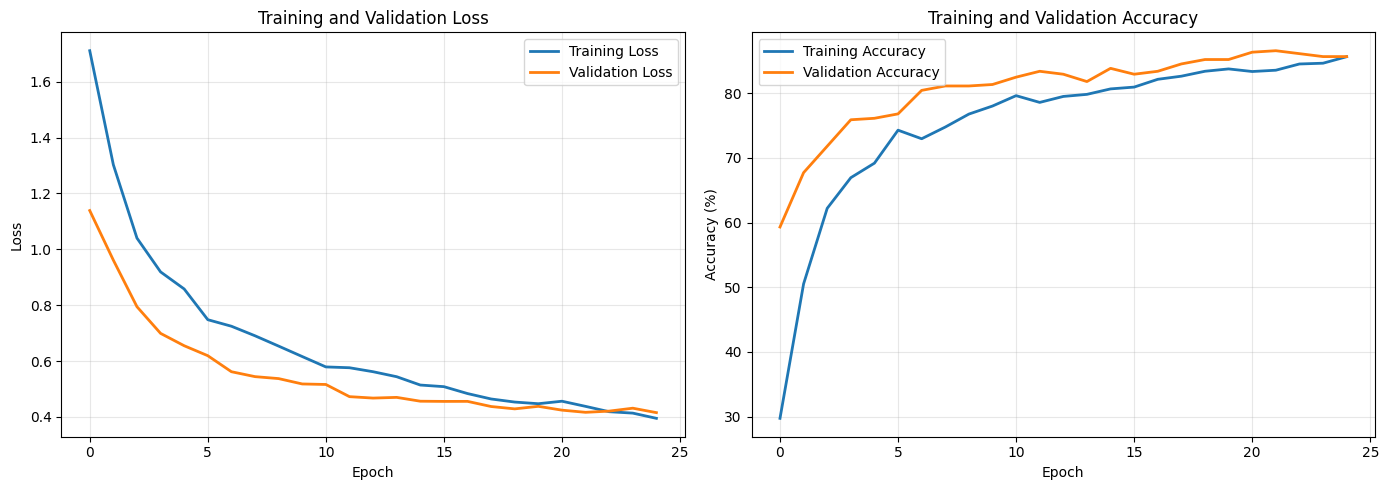

In [ ]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(history['train_loss'], label='Training Loss', linewidth=2)
axes[0].plot(history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(history['train_acc'], label='Training Accuracy', linewidth=2)
axes[1].plot(history['val_acc'], label='Validation Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 8.2 Confusion Matrix

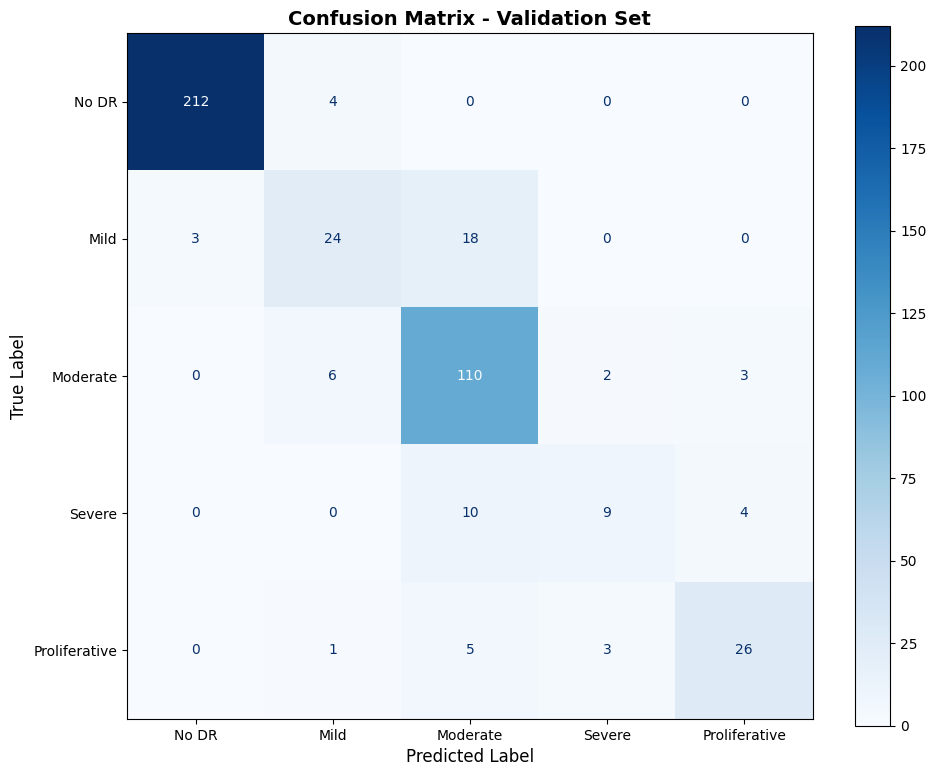


Normalized Confusion Matrix (%)
               No DR       Mild        Moderate    Severe      Proliferative
No DR                  98.1         1.9         0.0         0.0         0.0
Mild                    6.7        53.3        40.0         0.0         0.0
Moderate                0.0         5.0        90.9         1.7         2.5
Severe                  0.0         0.0        43.5        39.1        17.4
Proliferative           0.0         2.9        14.3         8.6        74.3


In [ ]:
# Plot confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(val_labels, val_preds)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_names
)

fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Validation Set', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

# Print normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
print("\nNormalized Confusion Matrix (%)")
print("="*50)
print(f"{'':15}", end="")
for name in class_names:
    print(f"{name:12}", end="")
print()

for i, name in enumerate(class_names):
    print(f"{name:15}", end="")
    for j in range(len(class_names)):
        print(f"{cm_normalized[i, j]:12.1f}", end="")
    print()

### 8.3 Grad-CAM visualizations

--- Generating Grad-CAM visualizations for each class ---
Visualizing Class No DR (ID: e4b0df29b96f) - True: No DR (Conf: 99.58%) - Pred: No DR (Conf: 99.58%)
Visualizing Class Mild (ID: db690e2d02f8) - True: Mild (Conf: 41.47%) - Pred: Moderate (Conf: 50.67%)
Visualizing Class Moderate (ID: 1e4b3b823b95) - True: Moderate (Conf: 90.58%) - Pred: Moderate (Conf: 90.58%)
Visualizing Class Severe (ID: ad2f0b9d059c) - True: Severe (Conf: 56.89%) - Pred: Severe (Conf: 56.89%)
Visualizing Class Proliferative (ID: 6194e0fff071) - True: Proliferative (Conf: 62.47%) - Pred: Proliferative (Conf: 62.47%)


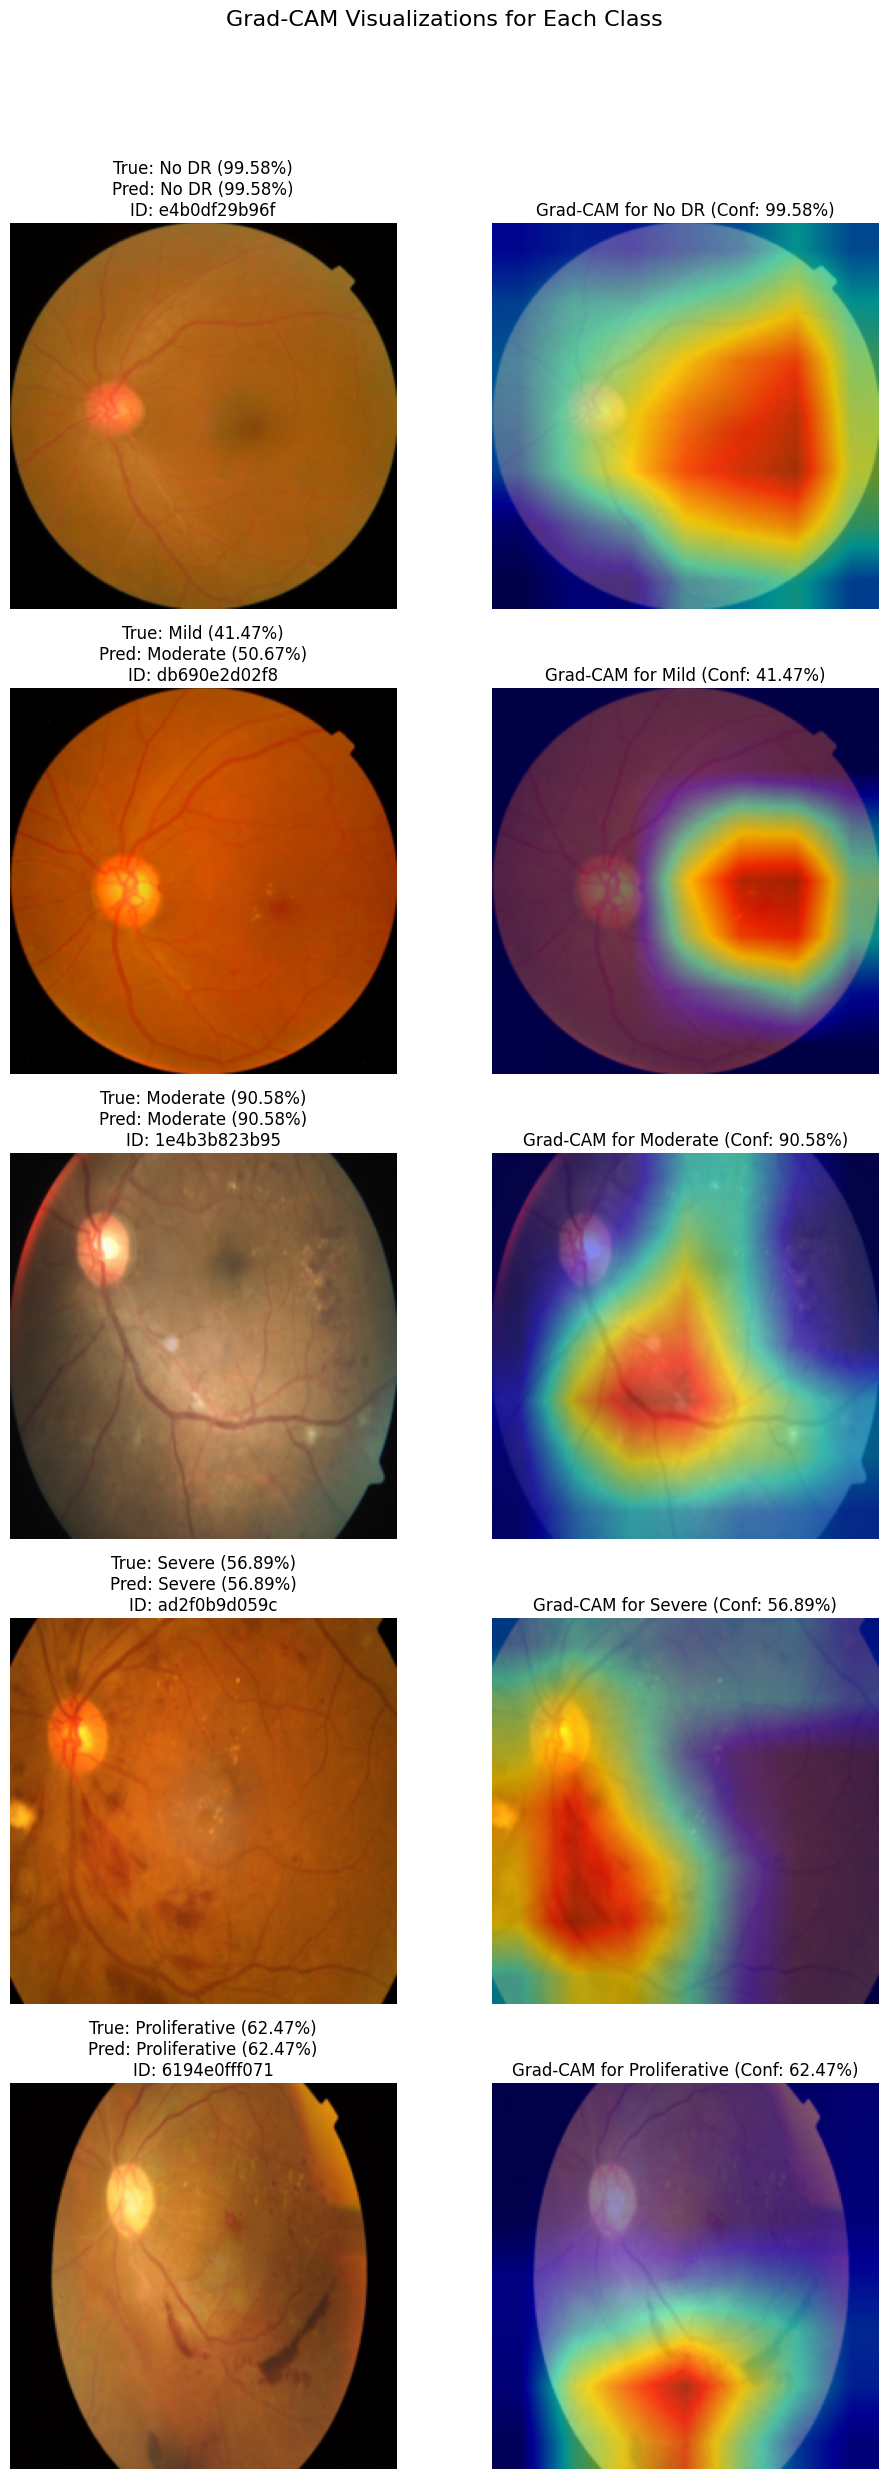

Grad-CAM visualization for each class complete.


In [ ]:
# Ensure necessary imports for Grad-CAM
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2 # For image processing functions used by show_cam_on_image
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F # For softmax

# --- Wrapper for multi-input model for Grad-CAM ---
# The GradCAM library expects a model.forward method that takes a single input tensor.
# Our model takes two (img_cnn, img_clip). This wrapper handles that.
class GradCAMWrapper(nn.Module):
    def __init__(self, original_model, img_clip_fixed_input):
        super().__init__()
        self.original_model = original_model
        self.img_clip_fixed_input = img_clip_fixed_input

    def forward(self, x):  # x will be img_cnn_tensor
        # The GradCAM will call this forward method with img_cnn_input.
        # We use the pre-defined self.img_clip_fixed_input for the CLIP branch.
        return self.original_model(x, self.img_clip_fixed_input)


print("--- Generating Grad-CAM visualizations for each class ---")

# 1. Collect one sample for each class from the validation dataset
samples_for_cam = {} # {true_label: (dataset_idx, images, true_label)}
for idx in range(len(val_dataset)):
    images, true_label = val_dataset[idx]
    if true_label not in samples_for_cam:
        samples_for_cam[true_label] = (idx, images, true_label)
    if len(samples_for_cam) == len(class_names):
        break # Found one for each class

if len(samples_for_cam) < len(class_names):
    print(f"Warning: Not all classes ({len(samples_for_cam)}/{len(class_names)}) found in validation dataset for Grad-CAM visualization.")

# Denormalization constants (assuming they are globally defined from previous cell)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Prepare figure for plotting
fig, axes = plt.subplots(len(samples_for_cam), 2, figsize=(10, 5 * len(samples_for_cam)))
fig.suptitle('Grad-CAM Visualizations for Each Class', fontsize=16, y=1.02) # Add a super title

# Ensure axes is always a 2D array for consistent indexing
if len(samples_for_cam) == 1:
    axes = np.expand_dims(axes, axis=0)

# Identify the target layer for DenseNet once
# 'norm5' is the final BatchNorm layer before the global average pooling in DenseNet121.
model.eval()
target_layer = model.densenet.features.norm5

# Loop through collected samples and generate plots
for row_idx, class_label in enumerate(sorted(samples_for_cam.keys())):
    dataset_idx, images, true_label = samples_for_cam[class_label]
    img_id = val_dataset.df.iloc[dataset_idx]['id_code']

    # Move image tensors to the device and add batch dimension
    img_cnn_tensor = images['cnn'].unsqueeze(0).to(device)
    img_clip_tensor = images['clip'].unsqueeze(0).to(device)

    # Denormalize the CNN image tensor for visualization purposes
    original_img_np = img_cnn_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)
    original_img_np = (original_img_np * std + mean)
    original_img_np = np.clip(original_img_np, 0, 1) # Ensure pixel values are between 0 and 1

    # Get model predictions and confidences
    with torch.no_grad():
        outputs = model(img_cnn_tensor, img_clip_tensor)
        probabilities = F.softmax(outputs, dim=1)
        pred_confidence, predicted_class_idx = torch.max(probabilities, 1)

    predicted_label = predicted_class_idx.item()
    pred_confidence = pred_confidence.item()
    true_confidence = probabilities[0, true_label].item()

    # Create wrapper model for Grad-CAM (specific to current img_clip_tensor)
    wrapper_model = GradCAMWrapper(model, img_clip_tensor)
    cam_extractor = GradCAM(model=wrapper_model, target_layers=[target_layer])

    # Generate CAM for the true class of the current sample
    targets = [ClassifierOutputTarget(true_label)]
    grayscale_cam = cam_extractor(input_tensor=img_cnn_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]  # Get the CAM for the first (and only) image in the batch

    # Overlay the CAM on the original image
    cam_image = show_cam_on_image(original_img_np, grayscale_cam, use_rgb=True)

    # Plot original image (left column)
    axes[row_idx, 0].imshow(original_img_np)
    axes[row_idx, 0].set_title(
        f"True: {class_names[true_label]} ({true_confidence:.2%})\nPred: {class_names[predicted_label]} ({pred_confidence:.2%})\nID: {img_id}"
    )
    axes[row_idx, 0].axis('off')

    # Plot CAM (right column)
    axes[row_idx, 1].imshow(cam_image)
    axes[row_idx, 1].set_title(f"Grad-CAM for {class_names[true_label]} (Conf: {true_confidence:.2%})")
    axes[row_idx, 1].axis('off')

    print(f"Visualizing Class {class_names[true_label]} (ID: {img_id}) - True: {class_names[true_label]} (Conf: {true_confidence:.2%}) - Pred: {class_names[predicted_label]} (Conf: {pred_confidence:.2%})")

plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout to prevent suptitle overlap
plt.show()
print("Grad-CAM visualization for each class complete.")